# Partial penetration

Thicker aquifers are mostly only partially penetrated by well screens. This is to save drilling and installation expences. When the aim of wells is to pump dry an excavation, shorter well screens may even reduce the amount of water to be pumped while enhancing the required shallow drawdown at the bottom of the excavation; this also saves water and energy.

With a fully penetrating well screen, the flow lines towards the well are essentially all virtually parallel and horizontal. This is also the case with partially penetrating well at distances larger than about 1.5 times the aquifer thickness. But at closer distances, the streamlines must converge towards the smaller screen. This causes vertical velocity components and larger velocities near the screen and, therefore, an extra loss of head. This head loss due to converging streamlines is the extra drawdown due to partial penetration.

If one compares the flow in the situation with a fully penetrating well screen with that of a partially penetrating screen at the same spot, one imagins that to obtain the flow in the case of the partially penetrating screen, one can take the case of the fully penetrating screen and superimpose above and below the partially penetrating screen an injection that makes the combined flow at r=0 above and below the screen equal zero. At the same time, this injection is extra extracted from the partially penetrating screen itself.

Hantush has developed an analytical solution for this additional flow, which can be superimposed on that of the case with a fully penetrating screen. This extra drawdown has to be added to the solution for the fully penetrating screen, no matter if this the flow is steady or transient. Of course, there is always a transient phase in the vicinity of the screen but because its effect is only felt within a short distancefrom the well, this transient phase so short that it can be ignored relative to the transients of the drawdown at larger distances, and especially also with respect to the transients in the case of water table aquifers where drawdown is determined by specific yield which is about two oerders slower than transiens determined by the elastic storage. Elastic storage works simultaneously with specific yield in water table aquifers, but is completely masked by the slow transients that the much larger specific yield causes.

The situation envisioned by Hantush (1955) is shown in the figure. The parameters are used in his formula below. For the outcome it does not matter whether distances are measured from the top of from the bottom of the aquifer, but one has to be consistent.

![Partial penetration](./pictures/partialPenetration.png)

Hantush's solution for the efect of partial penetration is as follows:

$$ s_{partialy} - s_{fully} = \frac Q {2 \pi kD} \times \frac {2 D} {\pi d } \sum_{n=1}^{\infty} \frac 1 n \left(
\sin \left( \frac {n \pi a} D \right) - \sin \left( \frac {n \pi b} D \right) \right) \cos \left( \frac {n \pi z} D \right) K_0 \left( \frac {n \pi r} D \right) $$

This solution can be readily implemented in Python, as is shown below:

In [3]:
from scipy.special import k0 # bessel function K0
import numpy as np

def dWpp(r, z, a, b, D):
    """Returns additional drawdown caused by partial penetration
    
    Solution by Hantush. See Kruseman and De Ridder (1994), p159.
    The real extra drawdown is Q/(2 pi kD) * dW
    Parmeters:
    ----------
    r : distance from the well
    z : distance from the bottom of the aquifer
    a : distance of top of screen to bottom of aquifer
    b : distance of bottom of creen to bottom of aquifer
    Returns:
    --------
    dW : ndarray size (Nz, Nr) containing all combinations of z and r
        Extra drawdown in terms of well function, which has still to be multiplied
        by Q/(2 pi kD).
    """
    tol = 1e-3
    pi  = np.pi
    d   = a - b
    r = np.array(r.ravel(), dtype = float)[np.newaxis,:]
    z = np.array(z.ravel(), dtype = float)[:,np.newaxis]
    alpha= pi * a/D
    beta = pi * b/D
    zeta = pi * z/D
    rho  = pi * r/D
    delta= pi * d/D
    maxiter = 500
    
    Dw = (z * r) * 0.
    dw0 = np.ones(Dw.shape)
    for n in np.arange(1.,maxiter+1.):
        dw1 = dw0
        dw0 = (np.sin(n * alpha) - np.sin(n * beta)) * np.cos(n * zeta) * k0( n * rho) / n
        Dw += dw0
        #print(np.sum(np.abs(dw1 + dw0)))
        if np.sum(np.abs(dw1 + dw0))< tol:
            break
    print("Iterations: {}".format(n))
    return (2./delta) * Dw

Let's apply  this solution and see if it works.

First we show the solution itself. This is the flow (head) that has to be superimposed to the situation with a fully penetrating screen. The head contours show
1. There is not only extraction from the screen but also injection above and below the screen, which, if superimposed to the case of the fully penetrating screen should yield no flow there.
2. There is not flow at some distance from the screen. In practice, one takes 1.5 times the aquifer thickness for this distance. If vertical anisotropy is large, this should be taken into account, then $r>1.5 D \sqrt{k_r / k_z }$

The code below shows an example in which the solution is used:

It is important to remark that a large number of terms (namely 220) was necessary to obtain the required accuracy. This implies that it is not easy to get the correct results by adding just a few terms by hand.

Iterations: 220.0


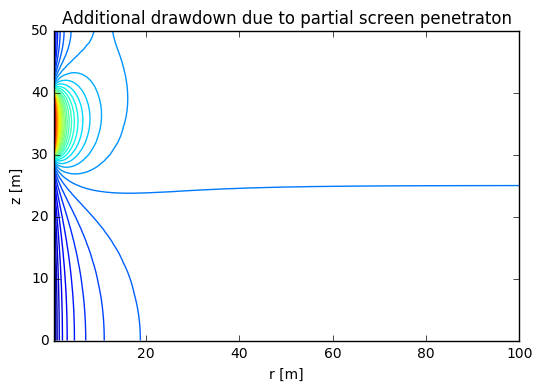

In [4]:
import matplotlib.pylab as plt

kD = 600.
S = 0.001
D = 50.
a = 40.
b = 30.
r0 = 0.3
r = np.logspace(np.log10(r0), 2., 41)
z = np.linspace(0., D, 51)

dw = dWpp(r, z, a, b, D)

fig =plt.figure()
ax = fig.add_subplot(111)
ax.set(xlabel='r [m]', ylabel='z [m]', title='Additional drawdown due to partial screen penetraton')
ax.contour(r, z, dw, 50)
plt.show()

As was said, it is difficult to see wether this result is correct. Therefore we'll add the drawdown due to a fully penetrating well to see whether the contours fo the drawdown near the screen concentrates around it and whether the flow above and below the partially penetrating screen is indeed zero.

To add the drawdown due to a fully penetrating well, we'll use that computed by the Theis formula, which we have at our disposition.

First define the Theis well function (once more) and also $u$ as a function of $r$ and $t$

In [5]:
from scipy.special import expi

def W(u): return -expi(-u) # Theis well function as was done earlier

u = lambda r, t : r**2 * S / (4 * kD * t) # the argument u

We now superimpose the Theis drawdown and the extra drawdown due to partial penetration.

Note: In the addition below, we implicitly make use of Python's broadcasting when we add the vector obtained for the fully penetrating drawdown to the array obtained from the extra partially penetrating drawdown. Numpy matches the different shapes for us and carries out the addition without complaints. (You can check the shapes by executing `s.shape`, `dWpp`($\cdots$)`.shape` etc).

In [6]:
Q = 1200
t = 1.0

s = Q / (4 * np.pi * kD) * W(u(r,t)) + Q/(2 * np.pi *  kD) *  dWpp(r, z, a, b, D)


Iterations: 220.0


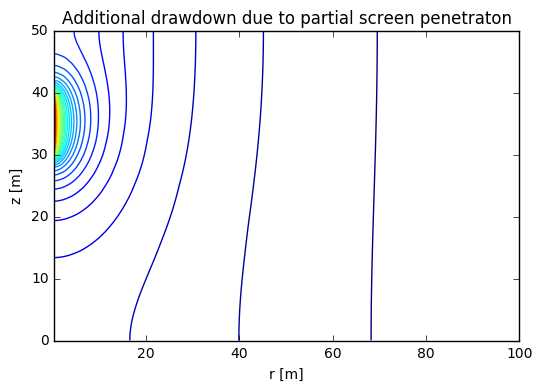

In [7]:
fig1 =plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set(xlabel='r [m]', ylabel='z [m]', title='Additional drawdown due to partial screen penetraton')
ax1.contour(r, z, s, 50)
plt.show()

This result shows that the contours indeed concentrate around the screen and only around the screen. The figure also shows that the head contours are perpendicular to the impervious top and bottom of the aquifer, as well as to the center of the well below and above the partially penetrating screen, as expected.

The extra drawdown in the screen itself may be computed by using a value of $z$ an $r$ that corresponds to the center of the screen. That is $z = (b+a)/2$ and $r=r0$, or take the average for a number of points along the screen.

The latter is better, because Hantush derived his formula for a uniform extraction along the screen. This implies that the head varies along the screen, at least somewhat, which does not correspond with a reality, where the head rather than the inflow is constant along the screen. Therefore an average for points along the screen is preferable. But the difference is expected to be negligeable in practice.

We an investigate this claim right away, using the available code.

In [8]:
import pdb
r = np.array([r0])  # distance to the well
z = np.linspace(b, a, 21) # elevation
ds = Q/(2 * np.pi *  kD) *  dWpp(r, z, a, b, D)  # partial penetration

print('mean of dpp along the screen: {:.2f} m'.format(np.mean(ds)))
print('max of dpp along the screen : {:.2f} m'.format(np.max(ds)))
print('dpp along for 21 points the screen:')
print('         z       dpp(z)')
for zz, dds in zip(z, ds):
    print("{:10.2f}  {:10.3f}".format(zz, dds[0]))

print("Drawdown by fully penetrating schreen {:.2f} m".format(Q / (4 * np.pi * kD) * W(u(r0,t))))

Iterations: 162.0
mean of dpp along the screen: 3.45 m
max of dpp along the screen : 3.98 m
dpp along for 21 points the screen:
         z       dpp(z)
     30.00       1.712
     30.50       2.696
     31.00       3.162
     31.50       3.432
     32.00       3.611
     32.50       3.738
     33.00       3.831
     33.50       3.898
     34.00       3.944
     34.50       3.971
     35.00       3.983
     35.50       3.979
     36.00       3.959
     36.50       3.922
     37.00       3.862
     37.50       3.777
     38.00       3.658
     38.50       3.487
     39.00       3.225
     39.50       2.768
     40.00       1.792
Drawdown by fully penetrating schreen 2.63 m


One sees that in this example the influence of partial penetration is larger than the total drawdown of the fully penetrating well (which is obvious from the plotted contours). Therefore, partial penetration is something to take into account.

When working out a pumping test with a partially penetrating screen, then the drawdown for piezometers closer than about 1.5D have to be corrected with the correction provided by Hantush's analytical solution. For piezometers installed at larger distances, such correction is not necessary.

When designing wells based on the expected drawdown (leading to a corresponding design of the pump), partial penetration must definitely be taken into account.